In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

**Dataset**


In [ ]:
df = pd.read_csv("/content/Patient survival dataset.csv")
df.shape

(10000, 20)

In [ ]:
df.head()

,PatientID,Gender,Age,Province,Ethnicity,TumorType,CancerStage,DiagnosisDate,TumorSize,Metastasis,TreatmentType,SurgeryDate,ChemotherapySessions,RadiationSessions,SurvivalStatus,FollowUpMonths,SmokingStatus,AlcoholUse,GeneticMutation,Comorbidities
0,CHN-00001,Male,32,Hunan,Han,Lung,I,2010-07-24,8.2,No,Radiation,2010-08-24,0,23,Alive,44,Current,NaN,NaN,NaN
1,CHN-00002,Male,66,Sichuan,Han,Lung,IV,2015-01-03,9.5,Yes,Chemotherapy,2015-03-24,11,0,Deceased,57,Never,Occasional,EGFR,"Hepatitis B, Hypertension"
2,CHN-00003,Other,26,Guangdong,Han,Lung,III,2022-03-26,9.3,Yes,Surgery,2022-07-14,0,0,Alive,40,Former,NaN,NaN,NaN
3,CHN-00004,Other,35,Anhui,Uyghur,Breast,III,2019-06-19,7.7,No,Surgery,2019-08-27,0,0,Deceased,45,Never,Occasional,KRAS,NaN
4,CHN-00005,Male,32,Guangdong,Han,Stomach,II,2012-02-07,7.3,No,Chemotherapy,NaN,4,0,Alive,42,Never,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PatientID             10000 non-null  object 
 1   Gender                10000 non-null  object 
 2   Age                   10000 non-null  int64  
 3   Province              10000 non-null  object 
 4   Ethnicity             10000 non-null  object 
 5   TumorType             10000 non-null  object 
 6   CancerStage           10000 non-null  object 
 7   DiagnosisDate         10000 non-null  object 
 8   TumorSize             10000 non-null  float64
 9   Metastasis            10000 non-null  object 
 10  TreatmentType         10000 non-null  object 
 11  SurgeryDate           4327 non-null   object 
 12  ChemotherapySessions  10000 non-null  int64  
 13  RadiationSessions     10000 non-null  int64  
 14  SurvivalStatus        10000 non-null  object 
 15  FollowUpMonths      

In [ ]:
df.drop(columns=["PatientID"], inplace=True)
print(df.isnull().sum())
df.dropna(inplace=True)
df["DiagnosisDate"] = pd.to_datetime(df["DiagnosisDate"])
df["SurgeryDate"] = pd.to_datetime(df["SurgeryDate"])
categorical_df = ["Gender", "Province", "Ethnicity", "TumorType", "CancerStage", "Metastasis", "TreatmentType", "SurvivalStatus", "SmokingStatus", "AlcoholUse", "GeneticMutation", "Comorbidities"]
for col in categorical_df:
  df[col] = LabelEncoder().fit_transform(df[col])

Gender                     0
Age                        0
Province                   0
Ethnicity                  0
TumorType                  0
CancerStage                0
DiagnosisDate              0
TumorSize                  0
Metastasis                 0
TreatmentType              0
SurgeryDate             5673
ChemotherapySessions       0
RadiationSessions          0
SurvivalStatus             0
FollowUpMonths             0
SmokingStatus              0
AlcoholUse              5921
GeneticMutation         7200
Comorbidities           3715
dtype: int64


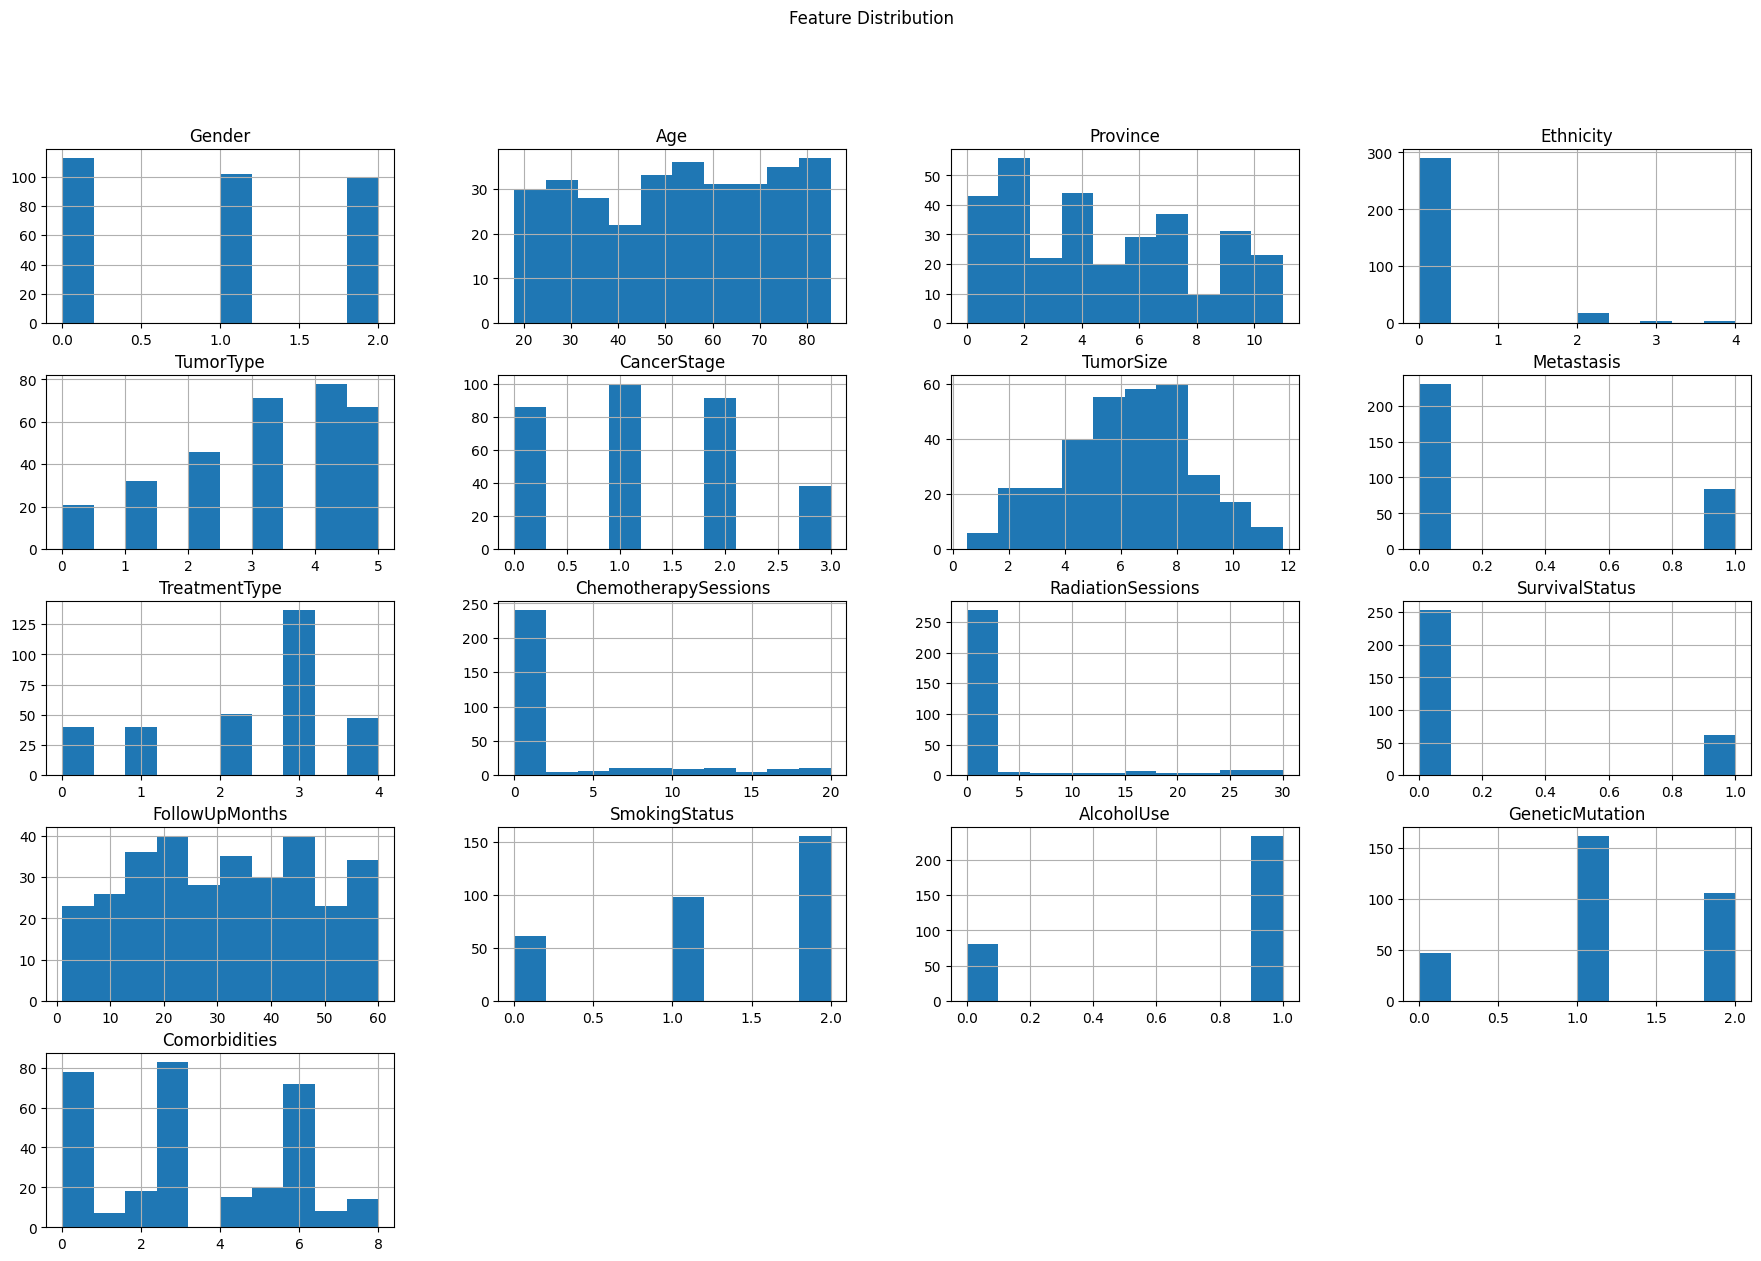

In [ ]:
numeric_df = df.select_dtypes(include=[np.number])
numeric_df.hist(figsize=(22,14))
plt.suptitle("Feature Distribution")
plt.show()

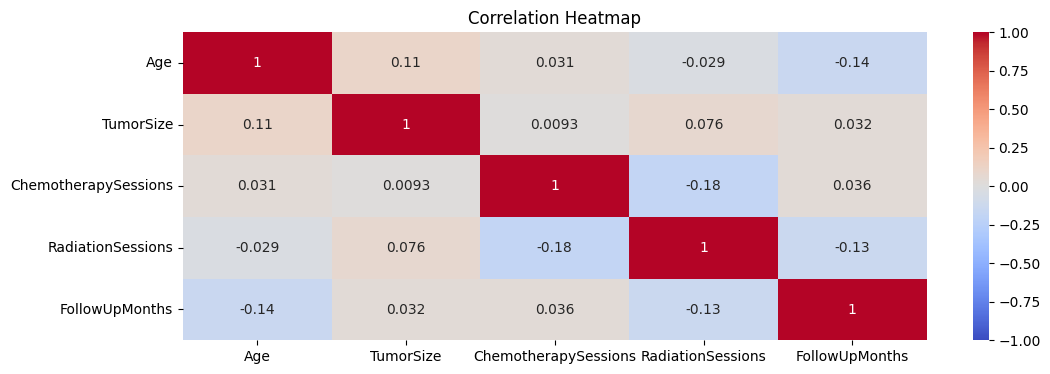

In [ ]:
#Heatmap
num_col = ['Age', 'TumorSize', 'ChemotherapySessions', 'RadiationSessions', 'FollowUpMonths']
plt.figure(figsize=(12,4))
num_matrix = df[num_col].corr()
sns.heatmap(num_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
#Patient survival rate
df['SurvivalStatus'] = df['SurvivalStatus'].map({1:'Alive', 0:'Deceased'})
print("\nSurvival rate by cancer stage:")
print(df.groupby('CancerStage')['SurvivalStatus'].value_counts(normalize=True).unstack())
print('\nSurvival rate by tumor type:')
print(df.groupby('TumorType')['SurvivalStatus'].value_counts(normalize=True).unstack())


Survival rate by cancer stage:
SurvivalStatus     Alive  Deceased
CancerStage                       
0                    NaN  1.000000
1                    NaN  1.000000
2               0.472527  0.527473
3               0.473684  0.526316

Survival rate by tumor type:
SurvivalStatus     Alive  Deceased
TumorType                         
0               0.142857  0.857143
1               0.093750  0.906250
2               0.195652  0.804348
3               0.183099  0.816901
4               0.217949  0.782051
5               0.238806  0.761194


**Feature Engineering**

In [ ]:
#Handling Missing Values
new_df = df.copy()
new_df['HadSurgery'] = new_df['SurgeryDate'].notnull().astype(int)
new_df = new_df.drop('SurgeryDate', axis=1)
new_df['AlcoholUse'] = new_df['AlcoholUse'].fillna('Unknown')
new_df['GeneticMutation'] = new_df['GeneticMutation'].fillna('None')
new_df['Comorbidities'] = new_df['Comorbidities'].fillna('None')

#Calculate the time since diagonosis
new_df['DiagnosisDate'] = pd.to_datetime(new_df['DiagnosisDate'])
current_date = pd.to_datetime('2025-03-19')
new_df['MonthsSinceDiagnosis'] = (current_date - new_df['DiagnosisDate']).dt.days/30.42
new_df = new_df.drop('DiagnosisDate', axis=1)

**Machine Learning Models**

In [ ]:
#SMOTE(Synthetic Minority Oversampling Technique)
X = new_df.drop('SurvivalStatus', axis=1)
y = new_df['SurvivalStatus']
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X,y)
new_df = pd.DataFrame(X_smote, columns=X.columns)
new_df['SurvivalStatus'] = y_smote

In [ ]:
#Train test data split
X = new_df.drop('SurvivalStatus', axis=1)
y= new_df['SurvivalStatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Model Implementation
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42)
}


In [ ]:
#Model evaluation using cross vaidation scores
cv_scores = {}

#Perform 5-fold cross validation for each model
for model_name, model in models.items():
  print(f"Training {model_name} with default parameters")
  results = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
  cv_scores[model_name] = results
  print(f"{model_name} Cross Validation Accuracy: {np.mean(results):.2f}")
  print("-"*50)

Training Decision Tree with default parameters
Decision Tree Cross Validation Accuracy: 0.87
--------------------------------------------------
Training Random Forest with default parameters
Random Forest Cross Validation Accuracy: 0.90
--------------------------------------------------
Training Logistic Regression with default parameters
Logistic Regression Cross Validation Accuracy: 0.83
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

**Model Selection & Hyperparameter Tuning**

In [ ]:
#Initializing models
model_dt = DecisionTreeClassifier(random_state=42)
model_rf = RandomForestClassifier(random_state=42)
model_lr = LogisticRegression(random_state=42)

In [ ]:
# Hyperparameter grids for RandomizedSearchCV

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

param_grid_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300],
}


In [ ]:
# Perform RandomizedSearchCV for each model
random_search_dt = RandomizedSearchCV(estimator=model_dt, param_distributions=param_grid_dt, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_rf = RandomizedSearchCV(estimator=model_rf, param_distributions=param_grid_rf, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_lr = RandomizedSearchCV(estimator=model_lr, param_distributions=param_grid_lr, n_iter=10, cv=5, scoring='accuracy', random_state=42)

In [ ]:
# Fit the models
random_search_dt.fit(X_train, y_train)
random_search_rf.fit(X_train, y_train)
random_search_lr.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   param_distributions={'C': [0.01, 0.1, 1, 10, 100],
                                        'max_iter': [100, 200, 300],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=42, scoring='accuracy')

In [ ]:
# Get the best model with best score
best_model = None
best_score = 0

if random_search_dt.best_score_ > best_score:
  best_score = random_search_dt.best_score_
  best_model = random_search_dt.best_estimator_

if random_search_rf.best_score_ > best_score:
  best_score = random_search_rf.best_score_
  best_model = random_search_rf.best_estimator_

if random_search_lr.best_score_ > best_score:
  best_score = random_search_lr.best_score_
  best_model = random_search_lr.best_estimator_

In [ ]:
print(f"Best Model : {best_model}")
print(f"Best Cross validation accuracy: {best_score:.2f}")

Best Model : RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)
Best Cross validation accuracy: 0.91


**Evaluation**

In [ ]:
# Evaluate based on test data
y_test_pred = best_model.predict(X_test)
print("Accuracy:\n", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Accuracy:
 0.9215686274509803
Confusion Matrix:
 [[47  1]
 [ 7 47]]
Classification Report:
               precision    recall  f1-score   support

       Alive       0.87      0.98      0.92        48
    Deceased       0.98      0.87      0.92        54

    accuracy                           0.92       102
   macro avg       0.92      0.92      0.92       102
weighted avg       0.93      0.92      0.92       102

